In [29]:
from ultralytics import YOLO
import cv2
from ultralytics.utils.plotting import Annotator
import math
from PIL import Image
import imutils
from imutils import perspective
from imutils import contours
from scipy.spatial import distance as dist
import numpy as np


In [30]:
model = YOLO('./runs/detect/yolov8m_climbing_crux_model6/weights/best.pt')
names = model.model.names

In [31]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [32]:
img = cv2.imread('./../datasets/images/test/23.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

In [33]:
h, w = img.shape[:2]

In [34]:
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

In [35]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [36]:
(cnts, _) = contours.sort_contours(cnts)
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),
          (255, 0, 255))
refObj = None

In [38]:
for c in cnts:
    if cv2.contourArea(c) < 100:
        continue
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    box = perspective.order_points(box)
    cX = np.average(box[:, 0])
    cY = np.average(box[:, 1])
    if refObj is None:
        (tl, tr, br, bl) = box
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
        D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
        refObj = (box, (cX, cY), D / 70)
        continue
    orig = img.copy()
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    cv2.drawContours(orig, [refObj[0].astype("int")], -1, (0, 255, 0), 2)
    refCoords = np.vstack([refObj[0], refObj[1]])
    objCoords = np.vstack([box, (cX, cY)])

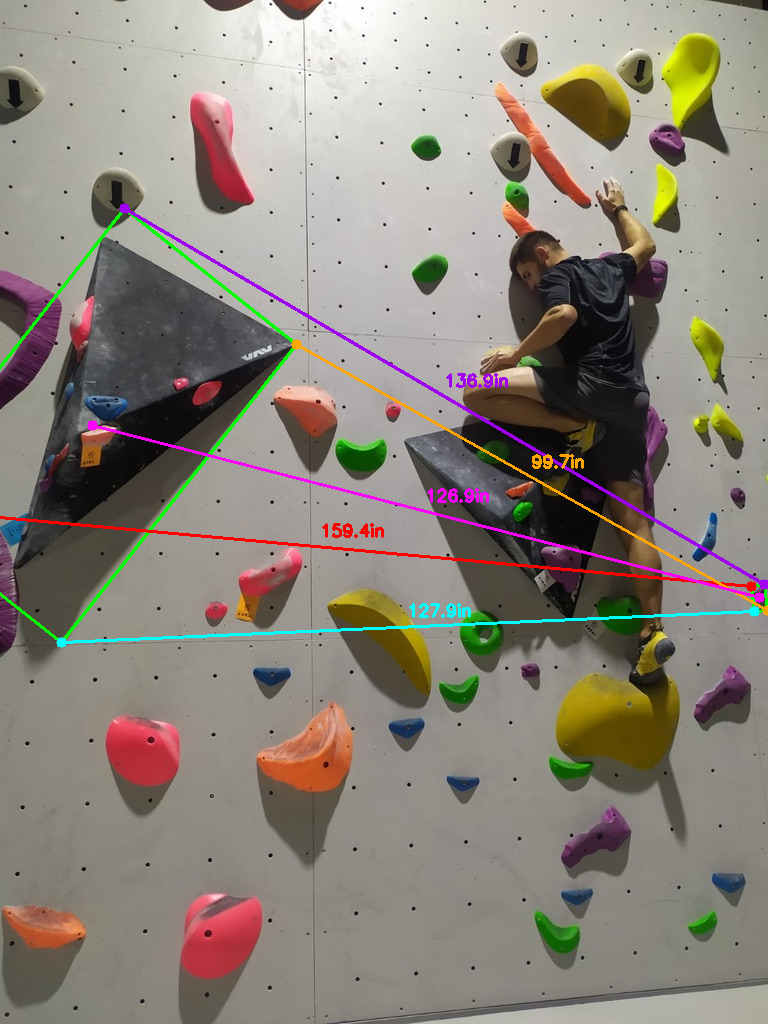

In [40]:
for ((xA, yA), (xB, yB), color) in zip(refCoords, objCoords, colors):
        cv2.circle(orig, (int(xA), int(yA)), 5, color, -1)
        cv2.circle(orig, (int(xB), int(yB)), 5, color, -1)
        cv2.line(orig, (int(xA), int(yA)), (int(xB), int(yB)),
                 color, 2)
        D = dist.euclidean((xA, yA), (xB, yB)) / refObj[2]
        (mX, mY) = midpoint((xA, yA), (xB, yB))
        cv2.putText(orig, "{:.1f}in".format(D), (int(mX), int(mY - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
preview = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
display(Image.fromarray(preview))

In [41]:
center_point = (w//2, h)

In [42]:
# Example calculation of pixel_per_meter for a given object size in pixels and real world size in meters.
real_world_size_m = 2  # meters
object_size_pixels = 200  # pixels
pixel_per_meter = object_size_pixels / real_world_size_m

In [43]:
txt_color, txt_background, bbox_clr = ((0, 0, 0), (255, 255, 255), (255, 0, 255))

In [44]:
annotator = Annotator(img, line_width=2)

In [45]:
results = model.track(img, persist=True)
boxes = results[0].boxes.xyxy.cpu()

0: 800x608 85 holds, 1 volume, 737.1ms
Speed: 7.9ms preprocess, 737.1ms inference, 16.8ms postprocess per image at shape (1, 3, 800, 608)


In [46]:
if results[0].boxes.id is not None:
    track_ids = results[0].boxes.id.int().cpu().tolist()

    for box, track_id in zip(boxes, track_ids):
        annotator.box_label(box, label=str(track_id), color=bbox_clr)
        annotator.visioneye(box, center_point)

        x1, y1 = int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)    # Bounding box centroid

        distance = (math.sqrt((x1 - center_point[0]) ** 2 + (y1 - center_point[1]) ** 2))/pixel_per_meter

        text_size, _ = cv2.getTextSize(f"Distance: {distance:.2f} m", cv2.FONT_HERSHEY_SIMPLEX,1.2, 3)
        cv2.rectangle(img, (x1, y1 - text_size[1] - 10),(x1 + text_size[0] + 10, y1), txt_background, -1)
        cv2.putText(img, f"Distance: {distance:.2f} m",(x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.2,txt_color, 3)

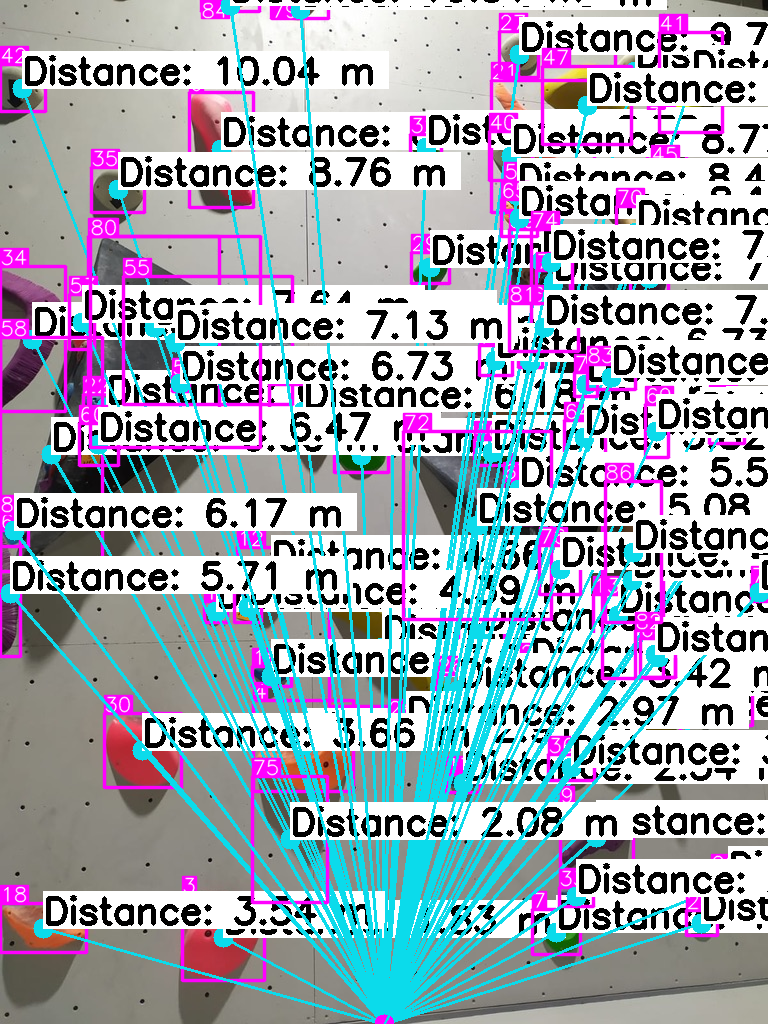

In [47]:
preview = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
display(Image.fromarray(preview))